In [205]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import datetime

In [206]:

# path0 = 'Q:\\SHA_KQ\\Digital Intelligence\\深度赋智-AI\\FTP\\hp_train\\2019 outbound\\'
# path1 = 'Q:\\SHA_KQ\\Digital Intelligence\\深度赋智-AI\\FTP\\hp_train\\2020 outbound\\'
# # path2 = 'Q:\\SHA_KQ\\Digital Intelligence\\深度赋智-AI\\FTP\\hp_train\\2021 outbound\\'
# path2 = 'Q:\\SHA_KQ\\Digital Intelligence\\深度赋智-AI\\FTP\\保乐力加_train\\outbound\\'
# %%time
# dfs0 = pd.DataFrame()
# for fname in os.listdir(path0):
#     if re.search(r'\.xls$', fname):
#         dfs0 = pd.concat(
#             [dfs0 ,pd.read_excel(path0 + fname)], 
#             axis = 0, 
#             ignore_index = True)

# dfs1 = pd.DataFrame()
# for fname in os.listdir(path1):
#     if re.search(r'\.xls$', fname):
#         dfs1 = pd.concat(
#             [dfs1 ,pd.read_excel(path1 + fname)], 
#             axis = 0, 
#             ignore_index = True)


# dfs2 = pd.DataFrame()
# for fname in os.listdir(path2):
#     if re.search(r'\.xls$', fname):
#         dfs2 = pd.concat(
#             [dfs2 ,pd.read_excel(path2 + fname)], 
#             axis = 0, 
#             ignore_index = True)
# dfs2 = dfs2.dropna(axis =1 , how = 'all')
 
# # path+
# dfs = pd.DataFrame()
# for fname in os.listdir(path):
#     if re.search(r'\.xls$', fname):
#         dfs = pd.concat(
#             [dfs ,pd.read_excel(path + fname)], axis = 0, ignore_index = True)
# prc_in = pd.DataFrame(dfs)
# prc_in = prc_in.drop(['仓库城市','仓库编号','Unnamed: 7'], axis = 1)
# prc_in.columns = ['time', 'sku','name','code','quant']

# dfs3 = pd.DataFrame()
# for fname in os.listdir(path2):
#     if re.search(r'\.xlsx$', fname):
#         dfs3 = pd.concat(
#             [dfs3 ,pd.read_excel(path3 + fname)], 
#             axis = 0, 
#             ignore_index = True)
# pd.set_option("display.max_rows", None, "display.max_columns", None)
  
# # dfs2.head(200)

In [703]:
# df = pd.read_clipboard()
# df.to_csv('./fas_057_rh.csv', index = False, encoding='utf_8_sig')
df = pd.read_csv('./fas_057_rh.csv')
df = df.fillna(method = 'ffill')

In [704]:
def date_mutate(col):
    df[col + '_time'] = df[col].str.slice(11,-1).astype(str)
    df[col] = df[col].str.slice(0,10)
    df[col + '_2'] = [datetime.strptime(i,'%H:%M:%S.%f').strftime('%H%M%S') for i in df[col + '_time']]
    return df.head(1)

# df.columns[df.columns.str.contains(r'date|DATE')].to_numpy()
# df[df['receipt_id'].str.findall(r'(货)').apply(len) > 1]

for i in df.columns[df.columns.str.contains(r'date|DATE')].to_numpy():
    date_mutate(i)



In [705]:
first_df = df.groupby(
    'CREATION_DATE_TIME_STAMP'
    )['CREATION_DATE_TIME_STAMP_2'].min().reset_index();first_df

# df[['CREATION_DATE_TIME_STAMP', 'CREATION_DATE_TIME_STAMP_2']].sort_values(by = 'CREATION_DATE_TIME_STAMP')


,CREATION_DATE_TIME_STAMP,CREATION_DATE_TIME_STAMP_2
0,2017-09-11,032456
1,2017-09-12,050737
2,2017-09-13,012211
3,2017-09-14,002402
4,2017-09-15,014709
...,...,...
888,2021-04-25,075955
889,2021-04-28,053557
890,2021-04-29,051023
891,2021-04-30,045253


In [706]:

first_df = first_df.merge(
    df, 
    on = ['CREATION_DATE_TIME_STAMP', 'CREATION_DATE_TIME_STAMP_2'], 
    how = 'inner')

# first_df2 = df.copy().groupby('CLOSE_DATE')[
#     ['receipt_id', 'receipt_date','total_lines', 'TOTAL_QTY']
#     ].sum().reset_index()

# first_df2.columns = ['CLOSE_DATE', 'ttl_line_cnt', 'ttl_qty_sum']

# first_df = first_df.merge(first_df2, how = 'inner', on = 'CLOSE_DATE')

In [722]:

train_first = first_df.groupby(
    'CREATION_DATE_TIME_STAMP'
    ).agg({'receipt_id':['nunique'], 
    'total_lines': ['sum'], 
    'TOTAL_CONTAINERS': 'sum', 
    'TOTAL_WEIGHT':'sum',
    'TOTAL_QTY': ['sum'],
    'CREATION_DATE_TIME_STAMP_2': 'max' }).reset_index()
    
train_full = df.groupby(
    'CREATION_DATE_TIME_STAMP'
    ).agg({'receipt_id':['nunique'], 
    'total_lines': ['sum'], 
    'TOTAL_CONTAINERS': 'sum', 
    'TOTAL_WEIGHT':'sum',
    'TOTAL_QTY': ['sum'],
    'CREATION_DATE_TIME_STAMP_2': 'max' }).reset_index()

train_full.columns = ['CREATION_DATE_TIME_STAMP','id', 'line_sum', 'container_sum', 'weight', 'qty', 'creat_time']
train_first.columns = ['CREATION_DATE_TIME_STAMP','id', 'line_sum', 'container_sum', 'weight', 'qty', 'creat_time']


<AxesSubplot:xlabel='index', ylabel='qty'>

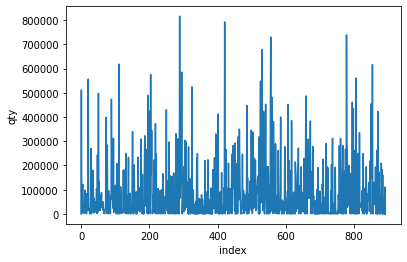

In [708]:
plt1 = (train_full.sort_values(
    by = 'CREATION_DATE_TIME_STAMP')['qty'] - train_first.sort_values(
        by = 'CREATION_DATE_TIME_STAMP')['qty'] ).reset_index()
sns.lineplot(x = 'index', y  ='qty', data = plt1)

In [723]:
train_first.index= pd.to_datetime(train_first['CREATION_DATE_TIME_STAMP'], yearfirst = True,  format='%Y-%m-%d')
train_full.index = train_full['CREATION_DATE_TIME_STAMP']
train_full.index = pd.DatetimeIndex(train_full.index);train_full.index

DatetimeIndex(['2017-09-11', '2017-09-12', '2017-09-13', '2017-09-14',
               '2017-09-15', '2017-09-18', '2017-09-19', '2017-09-20',
               '2017-09-21', '2017-09-22',
               ...
               '2021-04-14', '2021-04-16', '2021-04-19', '2021-04-22',
               '2021-04-23', '2021-04-25', '2021-04-28', '2021-04-29',
               '2021-04-30', '2021-05-07'],
              dtype='datetime64[ns]', name='CREATION_DATE_TIME_STAMP', length=893, freq=None)

In [724]:
train_full['CREATION_DATE_TIME_STAMP'] = pd.to_datetime(train_full['CREATION_DATE_TIME_STAMP'])
train_first['CREATION_DATE_TIME_STAMP'] = pd.to_datetime(train_first['CREATION_DATE_TIME_STAMP'])

---

In [711]:
# train_first.index= pd.to_datetime(train_first['CREATION_DATE_TIME_STAMP'], yearfirst = True,  format='%Y-%m-%d')
# train_first.pop('CREATION_DATE_TIME_STAMP')
# train_full.pop('CREATION_DATE_TIME_STAMP')
# train_full['qty'] = train_full['qty'].astype(int)
# train_first['qty'] = train_first['qty'].astype(int)
# # train_first.index = 

In [712]:
# train_first['qty2'] = train_full['qty'].to_numpy() ; train_first

# train_first = train_first.reset_index()
# train_first.drop(['qty2','CREATION_DATE_TIME_STAMP','creat_time'], axis =1) 

# sktime; timeseries only prediction on trainfull


In [713]:
train_full.index = train_full['CREATION_DATE_TIME_STAMP']
train_full.index = pd.DatetimeIndex(train_full.index);train_full.index
train_full = train_full.asfreq('D')
train_full = train_full.fillna(0);train_full

,CREATION_DATE_TIME_STAMP,id,line_sum,container_sum,weight,qty,creat_time
CREATION_DATE_TIME_STAMP,,,,,,,
2017-09-11,2017-09-11 00:00:00,1.0,2.0,22.0,22000.00,880.0,032456
2017-09-12,2017-09-12 00:00:00,9.0,30.0,96.0,850242.84,512046.0,084029
2017-09-13,2017-09-13 00:00:00,6.0,9.0,41.0,41290.00,1778.0,014356
2017-09-14,2017-09-14 00:00:00,11.0,49.0,140.0,121620.00,16690.0,071055
2017-09-15,2017-09-15 00:00:00,4.0,16.0,36.0,96619.20,93797.0,034049
...,...,...,...,...,...,...,...
2021-05-03,0,0.0,0.0,0.0,0.00,0.0,0
2021-05-04,0,0.0,0.0,0.0,0.00,0.0,0
2021-05-05,0,0.0,0.0,0.0,0.00,0.0,0


In [714]:
from sktime.forecasting.arima import AutoARIMA

from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.naive import NaiveForecaster
from sktime.regression import ComposableTimeSeriesForestRegressor

x = train_full.drop('qty', axis = 1)
y = train_full.loc[:,'qty']
x_train, x_test , y_train, y_test = temporal_train_test_split(x, y)

#
#  # fh = ForecastingHorizon(x_test, is_relative=False)
# forecaster = ComposableTimeSeriesForestRegressor(x = x_train, y = y_train)
# forecaster.fit(x_train ,y = y_train)
# y_pred = forecaster.predict(x_test)
# mean_absolute_percentage_error(y_test, y_pred)

fh = ForecastingHorizon(y_test.index, is_relative=False)
forecaster = NaiveForecaster(sp = 21)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh )
mean_absolute_percentage_error(y_test, y_pred)



1.1645328926277163

---

In [725]:
train_full

,CREATION_DATE_TIME_STAMP,id,line_sum,container_sum,weight,qty,creat_time
CREATION_DATE_TIME_STAMP,,,,,,,
2017-09-11,2017-09-11,1,2,22,22000.00,880.0,032456
2017-09-12,2017-09-12,9,30,96,850242.84,512046.0,084029
2017-09-13,2017-09-13,6,9,41,41290.00,1778.0,014356
2017-09-14,2017-09-14,11,49,140,121620.00,16690.0,071055
2017-09-15,2017-09-15,4,16,36,96619.20,93797.0,034049
...,...,...,...,...,...,...,...
2021-04-25,2021-04-25,6,9,55,113837.57,92622.0,080619
2021-04-28,2021-04-28,1,2,3,1290.24,1008.0,053557
2021-04-29,2021-04-29,1,1,10,12516.00,10080.0,051023


In [726]:
train_first['CREATION_DATE_TIME_STAMP'] = pd.to_datetime(train_first['CREATION_DATE_TIME_STAMP'])
train_full = train_full.reset_index(drop =True)
train_first = train_first.reset_index(drop =True)

In [727]:
train_full = train_full.merge(train_first, on = 'CREATION_DATE_TIME_STAMP', how = 'inner')

In [728]:
train_full.index = train_full['CREATION_DATE_TIME_STAMP']
train_full.index = pd.DatetimeIndex(train_full.index);train_full.index
train_full = train_full.asfreq('D')
train_full = train_full.fillna(0);train_full

,CREATION_DATE_TIME_STAMP,id_x,line_sum_x,container_sum_x,weight_x,qty_x,creat_time_x,id_y,line_sum_y,container_sum_y,weight_y,qty_y,creat_time_y
CREATION_DATE_TIME_STAMP,,,,,,,,,,,,,
2017-09-11,2017-09-11 00:00:00,1.0,2.0,22.0,22000.00,880.0,032456,1.0,2.0,22.0,22000.0,880.0,032456
2017-09-12,2017-09-12 00:00:00,9.0,30.0,96.0,850242.84,512046.0,084029,1.0,1.0,19.0,18600.0,744.0,050737
2017-09-13,2017-09-13 00:00:00,6.0,9.0,41.0,41290.00,1778.0,014356,1.0,1.0,1.0,100.0,4.0,012211
2017-09-14,2017-09-14 00:00:00,11.0,49.0,140.0,121620.00,16690.0,071055,1.0,1.0,9.0,8000.0,6000.0,002402
2017-09-15,2017-09-15 00:00:00,4.0,16.0,36.0,96619.20,93797.0,034049,1.0,2.0,13.0,12525.0,501.0,014709
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-03,0,0.0,0.0,0.0,0.00,0.0,0,0.0,0.0,0.0,0.0,0.0,0
2021-05-04,0,0.0,0.0,0.0,0.00,0.0,0,0.0,0.0,0.0,0.0,0.0,0
2021-05-05,0,0.0,0.0,0.0,0.00,0.0,0,0.0,0.0,0.0,0.0,0.0,0


In [729]:
train_full['CREATION_DATE_TIME_STAMP'] = train_full.index;train_full.dtypes

CREATION_DATE_TIME_STAMP    datetime64[ns]
id_x                               float64
line_sum_x                         float64
container_sum_x                    float64
weight_x                           float64
qty_x                              float64
creat_time_x                        object
id_y                               float64
line_sum_y                         float64
container_sum_y                    float64
weight_y                           float64
qty_y                              float64
creat_time_y                        object
dtype: object

In [730]:
x = train_full 

# x['CREATION_DATE_TIME_STAMP'] = x.index
x_train, x_test = temporal_train_test_split(x)
x_train

CREATION_DATE_TIME_STAMP    datetime64[ns]
id_x                               float64
line_sum_x                         float64
container_sum_x                    float64
weight_x                           float64
qty_x                              float64
creat_time_x                        object
id_y                               float64
line_sum_y                         float64
container_sum_y                    float64
weight_y                           float64
qty_y                              float64
creat_time_y                        object
dtype: object

In [733]:
# np.delete(x.columns.to_numpy(), ['qty_x', 'CREATION_DATE_TIME_STAMP'])

cols = [i for i in x.columns if i not in ['qty_x', 'CREATION_DATE_TIME_STAMP']]

In [734]:
from fbprophet import Prophet
# df = x[['CREATION_DATE_TIME_STAMP', 'qty']]
df = x_train 
df = df.rename({'CREATION_DATE_TIME_STAMP' : 'ds', 'qty_x': 'y'}, axis = 1)
m = Prophet()
[m.add_regressor(i) for i in cols]

m.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


TypeError: 'Figure' object is not subscriptable

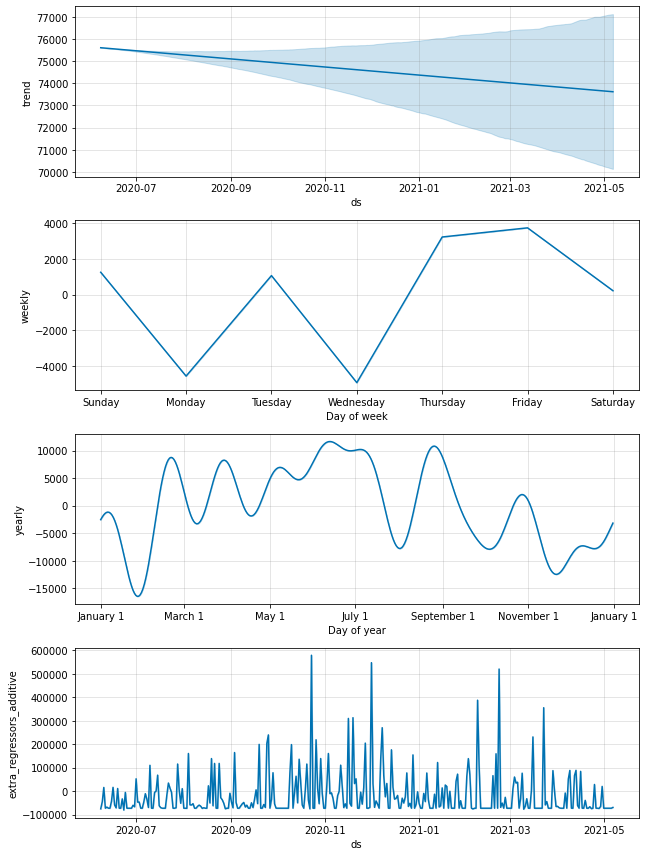

In [752]:
m.plot_components(m.predict(x_test))[1]

TypeError: 'Figure' object is not subscriptable

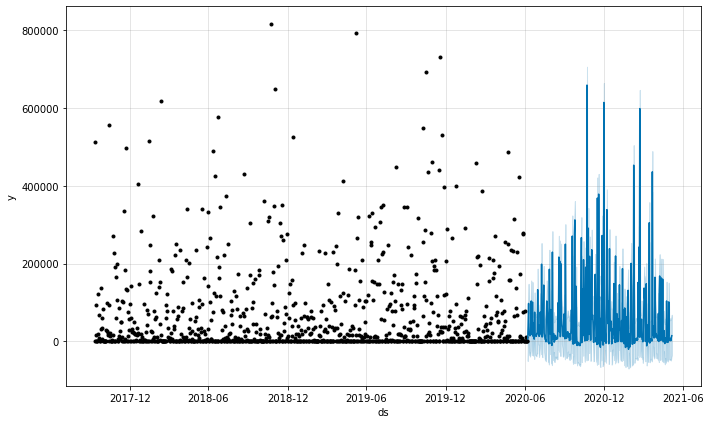

In [756]:
# %%warning = False
m.plot(m.predict(x_test))[0]

In [736]:
x_test = x_test.rename({'CREATION_DATE_TIME_STAMP' : 'ds', 'qty_x': 'y'}, axis = 1)
# m.predict(x_test)
mean_absolute_percentage_error(x_test['y'], m.predict(x_test)['yhat'])
# fig = m.plot_components(m.predict(x_test))

1.1565165627738292

---

# pseudo labeling

In [739]:
train_full['diff'] = train_full['qty_x'] - train_full['qty_y'] ==  0
train_full['diff'] = [1 if i == True else 0 for i in train_full['diff']]

In [767]:
x = train_full 
x_train, x_test = temporal_train_test_split(x)
x_train

,CREATION_DATE_TIME_STAMP,id_x,line_sum_x,container_sum_x,weight_x,qty_x,creat_time_x,id_y,line_sum_y,container_sum_y,weight_y,qty_y,creat_time_y,diff
CREATION_DATE_TIME_STAMP,,,,,,,,,,,,,,
2017-09-11,2017-09-11,1.0,2.0,22.0,22000.00,880.0,032456,1.0,2.0,22.0,22000.0,880.0,032456,1
2017-09-12,2017-09-12,9.0,30.0,96.0,850242.84,512046.0,084029,1.0,1.0,19.0,18600.0,744.0,050737,0
2017-09-13,2017-09-13,6.0,9.0,41.0,41290.00,1778.0,014356,1.0,1.0,1.0,100.0,4.0,012211,0
2017-09-14,2017-09-14,11.0,49.0,140.0,121620.00,16690.0,071055,1.0,1.0,9.0,8000.0,6000.0,002402,0
2017-09-15,2017-09-15,4.0,16.0,36.0,96619.20,93797.0,034049,1.0,2.0,13.0,12525.0,501.0,014709,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-03,2020-06-03,9.0,14.0,43.0,2985.00,552.0,084515,1.0,2.0,4.0,500.0,8.0,005138,0
2020-06-04,2020-06-04,3.0,10.0,60.0,18161.00,11051.0,075502,1.0,1.0,23.0,16236.0,10824.0,015913,0
2020-06-05,2020-06-05,0.0,0.0,0.0,0.00,0.0,0,0.0,0.0,0.0,0.0,0.0,0,1


In [769]:
from fbprophet import Prophet 
df_lb = x_train 
cols_lb = [i for i in df_lb.columns 
    if i not in ['diff','qty_x','creat_time_x','creat_time_y','CREATION_DATE_TIME_STAMP']]

df_lb = df_lb.drop(['creat_time_x','creat_time_y', 'qty_x'], axis =1 )
df_lb = df_lb.rename({'CREATION_DATE_TIME_STAMP' : 'ds', 'diff': 'y'}, axis = 1)
m = Prophet()
[m.add_regressor(i) for i in cols_lb]

m.fit(df_lb)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [781]:
# ?mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import  mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import mean_absolute_error
from sklearn.metrics import accuracy_score

In [782]:
x_test

,CREATION_DATE_TIME_STAMP,id_x,line_sum_x,container_sum_x,weight_x,qty_x,creat_time_x,id_y,line_sum_y,container_sum_y,weight_y,qty_y,creat_time_y,diff
CREATION_DATE_TIME_STAMP,,,,,,,,,,,,,,
2020-06-08,2020-06-08,1.0,10.0,41.0,2400.00,1496.0,003649,1.0,10.0,41.0,2400.0,1496.0,003649,1
2020-06-09,2020-06-09,8.0,18.0,38.0,29711.40,17719.0,082121,1.0,4.0,8.0,26027.1,12672.0,002716,0
2020-06-10,2020-06-10,11.0,20.0,71.0,93881.41,68210.0,085712,1.0,1.0,1.0,18816.0,14112.0,052734,0
2020-06-11,2020-06-11,1.0,3.0,10.0,0.00,400.0,084513,1.0,3.0,10.0,0.0,400.0,084513,1
2020-06-12,2020-06-12,3.0,4.0,8.0,50.00,190.0,081937,1.0,2.0,2.0,50.0,2.0,065749,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-03,2021-05-03,0.0,0.0,0.0,0.00,0.0,0,0.0,0.0,0.0,0.0,0.0,0,1
2021-05-04,2021-05-04,0.0,0.0,0.0,0.00,0.0,0,0.0,0.0,0.0,0.0,0.0,0,1
2021-05-05,2021-05-05,0.0,0.0,0.0,0.00,0.0,0,0.0,0.0,0.0,0.0,0.0,0,1


In [787]:
x_test = x_test.drop(['creat_time_x','creat_time_y', 'qty_x'], axis =1 )
x_test = x_test.rename({'CREATION_DATE_TIME_STAMP' : 'ds', 'diff': 'y'}, axis = 1)
# m.predict(x_test)
mean_absolute_error(x_test['y'], m.predict(x_test)['yhat'])
# fig = m.plot_components(m.predict(x_test))

0.12343830658552758

In [794]:

from prophet.diagnostics import cross_validation,performance_metrics
df_cv = cross_validation(m, initial='365 days', period='31 days', horizon = '180 days')


INFO:prophet:Making 15 forecasts with cutoffs between 2018-10-02 00:00:00 and 2019-12-10 00:00:00
100%|██████████| 15/15 [00:57<00:00,  3.80s/it]


In [795]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-10-03,0.846138,0.641468,1.029040,1,2018-10-02
1,2018-10-04,0.868635,0.680062,1.057497,1,2018-10-02
2,2018-10-05,0.083076,-0.121703,0.272282,1,2018-10-02
3,2018-10-06,1.012707,0.814728,1.195686,1,2018-10-02
4,2018-10-07,1.029436,0.843121,1.216669,1,2018-10-02


In [796]:
performance_metrics(df_cv)

INFO:prophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,smape,coverage
0,18 days,0.033933,0.184209,0.092036,inf,1.375705,0.937037
1,19 days,0.033099,0.181932,0.089798,inf,1.368152,0.944444
2,20 days,0.030285,0.174027,0.087698,inf,1.383306,0.944444
3,21 days,0.027336,0.165335,0.085658,inf,1.384595,0.944444
4,22 days,0.028204,0.167939,0.088290,inf,1.406642,0.937037
...,...,...,...,...,...,...,...
158,176 days,0.035701,0.188947,0.099088,inf,1.378502,0.929630
159,177 days,0.038933,0.197315,0.103192,inf,1.384397,0.922222
160,178 days,0.041389,0.203442,0.104433,inf,1.368484,0.922222
161,179 days,0.037322,0.193188,0.099896,inf,1.360990,0.929630


In [ ]:
import itertools
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(df)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

# aaa

In [749]:
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn import model_selection
cv_split = model_selection.ShuffleSplit(
    n_splits = 6, 
    test_size = .25, 
    # max_train_size = .75
    )
alg1 = Lasso()

cv_results_1 = model_selection.cross_validate(
    alg1, 
    train_first.drop(['qty2','CREATION_DATE_TIME_STAMP','creat_time'], axis =1) , train_first['qty2'].to_numpy(), 
    cv  = cv_split, scoring='neg_mean_absolute_percentage_error')


cv_results_1['test_score'].mean()

KeyError: "['qty2'] not found in axis"

In [338]:
from sklearn.ensemble import RandomForestRegressor
alg2 = RandomForestRegressor(n_estimators = 34, 
        max_depth = 61,
        min_samples_split = 3, 
        min_samples_leaf=4, 
        # max_leaf_nodes = 31
        )
cv_results_2 = model_selection.cross_validate(
        alg2, 
        train_first, 
        train_full['qty'], 
        cv  = cv_split, scoring='neg_mean_absolute_percentage_error')
cv_results_2['test_score'].mean()

-232.76419329714838

In [330]:
alg2.fit(train_first,train_full['qty']).predict(train_first)

array([ 46535.93848039, 266403.40217087,  19529.51666667,  62376.25070028,
        75254.13444742, 111546.50318627,  68106.13504902, 138158.88711485,
        45976.27696078,  70012.99635854,  63572.22521008, 156882.70714286,
        57377.74453782,  66635.18651961,  73667.00910364,  86934.0877451 ,
       127749.24509804,  45824.52941176, 151389.71057423,  52619.3219888 ,
        38503.26713352, 274795.87605042, 105436.59481793,  72376.25637255,
        26494.13011204,  24766.71372549,  28538.93872549,  35923.18979501,
        39476.05686275, 122834.45336134, 101688.1464986 ,  80060.19093137,
       139255.12706583,  57453.8075121 ,  93360.09068627, 176030.04488796,
       152534.85406162,  42788.32303922, 147817.29509804,  48381.53104575,
        46951.12303922, 123375.55014006,  41718.5912656 ,  80455.64803922,
        43620.54789916, 124502.65751634, 121356.54576331,  30447.95178571,
       272968.68172269,  63672.91435574,  97555.68809524, 320435.14289216,
       120045.56827731, 1

In [344]:
from sklearn.neural_network import MLPRegressor
alg3 = MLPRegressor(
    hidden_layer_sizes = (891, 891, 450, 135), 
    max_iter=1000,
    verbose=True, 
    activation = 'identity', 
    solver = 'adam', learning_rate = 'adaptive')
cv_results_3 = model_selection.cross_validate(
    alg3, train_first,train_full['qty'], 
    cv  = cv_split, 
    scoring='neg_mean_absolute_percentage_error')
cv_results_3['test_score'].mean()

Iteration 1, loss = 9840332447.91429901
Iteration 2, loss = 9823633812.44610023
Iteration 3, loss = 9285683588.69616127
Iteration 4, loss = 9129133414.94727898
Iteration 5, loss = 9087299891.99265099
Iteration 6, loss = 9007139735.40104866
Iteration 7, loss = 8958141045.89183617
Iteration 8, loss = 9174486371.70582771
Iteration 9, loss = 8999906673.59621048
Iteration 10, loss = 9008252087.24812508
Iteration 11, loss = 9135441568.93227386
Iteration 12, loss = 9023088745.45179367
Iteration 13, loss = 9055065348.78659058
Iteration 14, loss = 9008845034.70876312
Iteration 15, loss = 9011032980.04362488
Iteration 16, loss = 9028369498.72106552
Iteration 17, loss = 8994303248.62904358
Iteration 18, loss = 9134571263.38923264
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 11436659028.09517670
Iteration 2, loss = 11498963090.90554428
Iteration 3, loss = 10332312066.27833366
Iteration 4, loss = 10247012589.37348747
Iteration 5, loss

-123.86910109178324

In [347]:
from sklearn.neural_network import MLPRegressor
alg3 = MLPRegressor(
    hidden_layer_sizes = (1120, 850, 450, 135), 
    max_iter=1000,
    verbose=True, 
    activation = 'relu', 
    solver = 'adam', 
    learning_rate = 'adaptive',
    warm_start = True,
    early_stopping = True
    )
cv_results_3 = model_selection.cross_validate(
    alg3, train_first,train_full['qty'], 
    cv  = cv_split, 
    scoring='neg_mean_absolute_percentage_error')
cv_results_3['test_score'].mean()

Iteration 1, loss = 11462717042.93061256
Validation score: -0.545942
Iteration 2, loss = 10474969752.80696106
Validation score: -0.979483
Iteration 3, loss = 10201776302.60164261
Validation score: -0.483464
Iteration 4, loss = 9848932678.67110825
Validation score: -0.499403
Iteration 5, loss = 10556054171.12208748
Validation score: -0.561567
Iteration 6, loss = 10807036677.99097633
Validation score: -0.548124
Iteration 7, loss = 10648495341.05313301
Validation score: -0.480177
Iteration 8, loss = 10189507009.83472633
Validation score: -0.427528
Iteration 9, loss = 9674814488.44912338
Validation score: -0.681424
Iteration 10, loss = 10125834983.31689453
Validation score: -1.070531
Iteration 11, loss = 10299989791.72861671
Validation score: -0.655199
Iteration 12, loss = 9433427306.25110817
Validation score: -0.486642
Iteration 13, loss = 9584059852.33731461
Validation score: -0.495589
Iteration 14, loss = 9752590158.92021942
Validation score: -0.497153
Iteration 15, loss = 9676567073.88

-186.27219196212357